<a href="https://colab.research.google.com/github/Pardhu156/MNIST-GAN/blob/main/Basic_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Mar  8 19:32:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   46C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

##Import Libraries


In [2]:
import torch,pdb
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

##Visualization Function


In [3]:
def show(tensor,ch=1,size=(28,28),num=16):
  #tensor=128*784   (128-batch size,784-28*28 pixels)
  data=tensor.detach().cpu().view(-1,ch,*size)  #16 *   1*28*28
  grid=make_grid(data[ :num],nrow=4).permute(1,2,0)  #28*28*1
  plt.imshow(grid)
  plt.show()

##Set up of Main and Hyper Parameters


In [4]:
epochs=500
cur_step=0
info_step=300
mean_gen_loss=0
mean_disc_loss=0

z_dim=64
lr=0.00001
loss_fun=nn.BCEWithLogitsLoss()

bs=128
device='cuda'

dataloader=DataLoader(MNIST('.',download=True,transform=transforms.ToTensor()),batch_size=bs,shuffle=True)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 16.1MB/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 481kB/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 10.6MB/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



##Generator Block


In [5]:
def genBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.BatchNorm1d(out),
      nn.ReLU(inplace=True)
  )

class Generator(nn.Module):
  def __init__(self,z_dim=64,i_dim=784,h_dim=128):
    super().__init__()
    self.gen=nn.Sequential(
        genBlock(z_dim,h_dim),
        genBlock(h_dim,h_dim*2),
        genBlock(h_dim*2,h_dim*4),
        genBlock(h_dim*4,h_dim*8),
        nn.Linear(h_dim*8,i_dim),
        nn.Sigmoid()
    )
  def forward(self,noise):
    return self.gen(noise)

def gen_noise(number,z_dim):
  return torch.randn(number,z_dim).to(device)

##Discriminator Block

In [6]:
def discBlock(inp,out):
  return nn.Sequential(
      nn.Linear(inp,out),
      nn.LeakyReLU(0.2)
  )

class Discriminator(nn.Module):
  def __init__(self,i_dim=784,h_dim=256):
    super().__init__()
    self.disc=nn.Sequential(
        discBlock(i_dim,h_dim*4),
        discBlock(h_dim*4,h_dim*2),
        discBlock(h_dim*2,h_dim),
        nn.Linear(h_dim,1)
    )
  def forward(self,image):
   return self.disc(image)

In [7]:
gen=Generator(z_dim).to(device)
gen_optim=torch.optim.Adam(gen.parameters(),lr=lr)
gen

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)

In [8]:
disc=Discriminator().to(device)
disc_optim=torch.optim.Adam(disc.parameters(),lr=lr)
disc

Discriminator(
  (disc): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=1024, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (1): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (2): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): LeakyReLU(negative_slope=0.2)
    )
    (3): Linear(in_features=256, out_features=1, bias=True)
  )
)

In [9]:
x,y=next(iter(dataloader))  #y is label and x is empty set of 128 images with 1*28*28(default dimensions of MNIST dataset)
print(x.shape,y.shape)
print(y[:10])
print(y.shape)

torch.Size([128, 1, 28, 28]) torch.Size([128])
tensor([4, 3, 0, 1, 2, 9, 7, 0, 4, 9])
torch.Size([128])


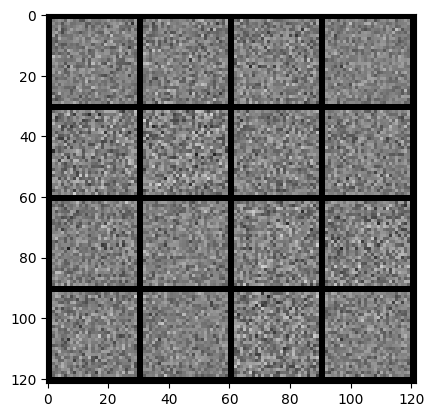

tensor([[-1.0647, -0.0840, -1.8087,  ...,  0.1982, -0.5345,  0.0332],
        [ 1.4251,  0.5538,  0.3911,  ...,  0.2798, -0.4753,  0.0077],
        [-0.5556, -0.0031,  0.1171,  ..., -0.1024, -0.3295, -0.3700],
        ...,
        [-0.8290, -0.1339, -1.0903,  ...,  0.1218, -0.4548,  1.0506],
        [ 0.0776, -0.2379, -1.4586,  ..., -0.7635,  1.2378, -1.6418],
        [ 0.2257, -0.5170,  0.5243,  ..., -0.8063,  0.5082,  0.7095]],
       device='cuda:0')


In [10]:
noise=gen_noise(bs,z_dim)
show(gen(noise))   #initial untrained noise vector
print(noise)

##Calculating the loss


##Generator loss


In [11]:
def calc_gen_loss(loss_fun,gen,disc,number,z_dim):
  noise=gen_noise(number,z_dim)
  fake=gen(noise)
  pred=disc(fake)
  target=torch.ones_like(pred)
  gen_loss=loss_fun(pred,target)
  return gen_loss

##Discriminator loss


In [12]:
def calc_disc_loss(loss_fun,gen,disc,number,real,z_dim):
  noise=gen_noise(number,z_dim)
  fake=gen(noise)
  disc_pred=disc(fake.detach())
  disc_fake_target=torch.zeros_like(disc_pred)
  disc_fake_loss=loss_fun(disc_pred,disc_fake_target)

  disc_real_pred=disc(real)
  disc_real_target=torch.ones_like(disc_real_pred)
  disc_real_loss=loss_fun(disc_real_pred,disc_real_target)

  disc_loss=(disc_fake_loss+disc_real_loss)/2
  return disc_loss

##Training

  0%|          | 0/469 [00:00<?, ?it/s]

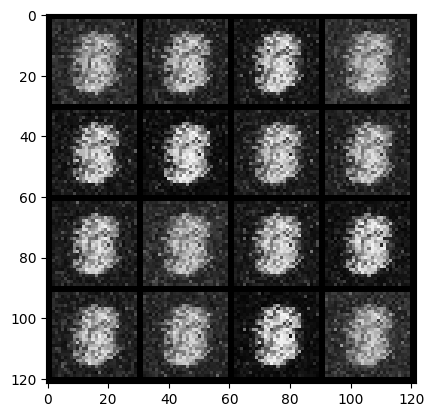

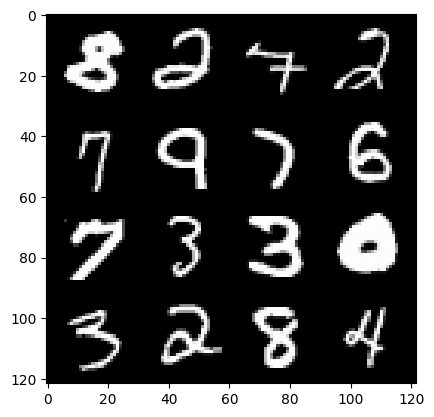

0: step 300 / Gen loss: 1.9291238439083112 / disc_loss: 0.34842630406220754


  0%|          | 0/469 [00:00<?, ?it/s]

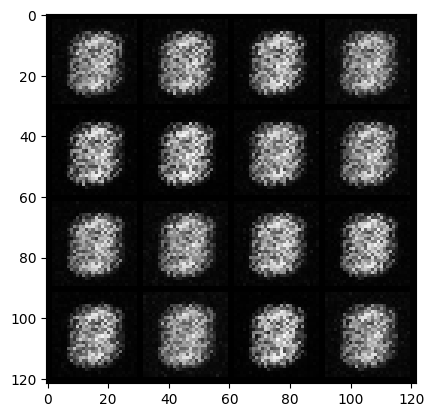

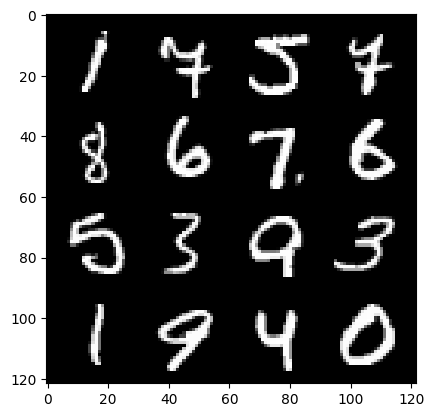

1: step 600 / Gen loss: 3.439877572854361 / disc_loss: 0.11478081780175368


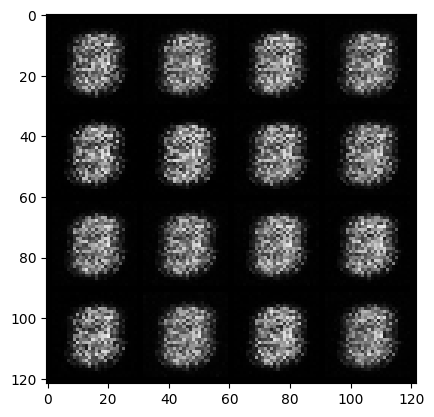

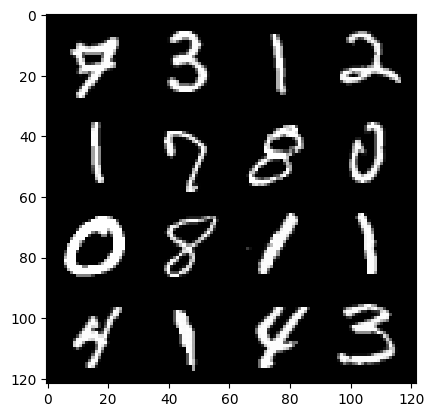

1: step 900 / Gen loss: 3.5878391989072163 / disc_loss: 0.048362964621434607


  0%|          | 0/469 [00:00<?, ?it/s]

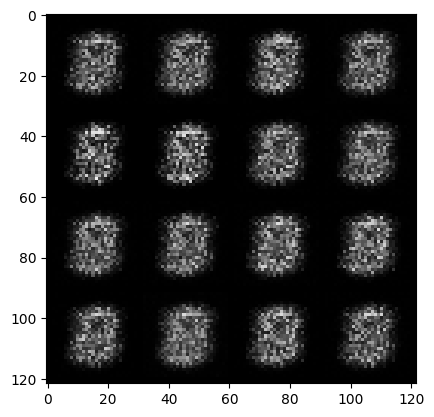

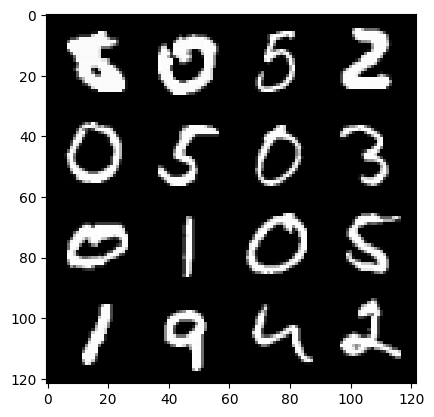

2: step 1200 / Gen loss: 3.7242226942380245 / disc_loss: 0.030988970647255563


  0%|          | 0/469 [00:00<?, ?it/s]

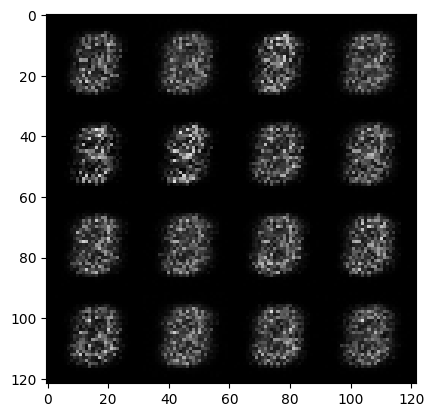

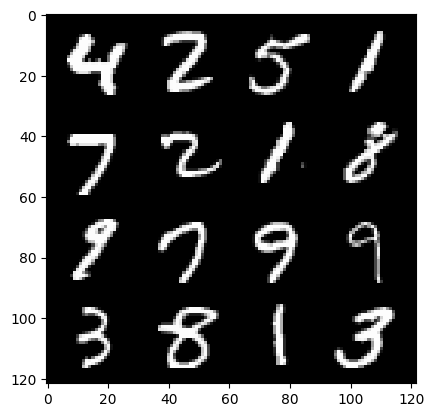

3: step 1500 / Gen loss: 3.480387166341146 / disc_loss: 0.040461822263896496


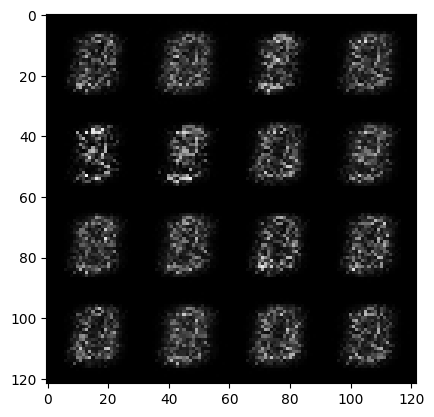

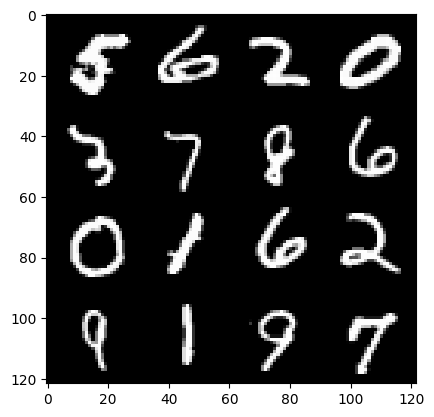

3: step 1800 / Gen loss: 3.3624226252237945 / disc_loss: 0.04983489486078419


  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [13]:
for epoch in range(epochs):
  for real,_ in tqdm(dataloader):
    ###discriminator:
    disc_optim.zero_grad()

    curr_size=len(real)   #128*1*28*28
    real=real.view(curr_size,-1)   #128*784
    real=real.to(device)

    disc_loss=calc_disc_loss(loss_fun,gen,disc,curr_size,real,z_dim)
    disc_loss.backward(retain_graph=True)
    disc_optim.step()


    ###generator
    gen_optim.zero_grad()
    curr_size=len(real)
    gen_loss=calc_gen_loss(loss_fun,gen,disc,curr_size,z_dim)
    gen_loss.backward(retain_graph=True)
    gen_optim.step()

    ###visualtization
    mean_gen_loss+=gen_loss.item()/info_step
    mean_disc_loss+=disc_loss.item()/info_step
    if cur_step>0 and cur_step%info_step==0:
      fake_noise=gen_noise(curr_size,z_dim)
      fake=gen(noise)
      show(fake)
      show(real)
      print(f"{epoch}: step {cur_step} / Gen loss: {mean_gen_loss} / disc_loss: {mean_disc_loss}")
      mean_gen_loss, mean_disc_loss=0,0
    cur_step=cur_step+1